In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
def set_seed(seed_value=42):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed()

Using device: cpu


In [2]:
# Custom dataset for BERT
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [3]:
# Load datasets
print("Loading datasets...")
train_df = pd.read_csv('train_dataset.csv')
val_df = pd.read_csv('val_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

print(f"Training set: {train_df.shape[0]} samples")
print(f"Validation set: {val_df.shape[0]} samples")
print(f"Test set: {test_df.shape[0]} samples")

# Check for text column
text_column = 'processed_text' if 'processed_text' in train_df.columns else 'Text'
print(f"Using text column: {text_column}")

# Handle missing values
train_df[text_column] = train_df[text_column].fillna("").astype(str)
val_df[text_column] = val_df[text_column].fillna("").astype(str)
test_df[text_column] = test_df[text_column].fillna("").astype(str)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create datasets
batch_size = 16  # Adjust this if needed

train_dataset = TextClassificationDataset(
    texts=train_df[text_column].tolist(),
    labels=train_df['Label'].tolist(),
    tokenizer=tokenizer
)

val_dataset = TextClassificationDataset(
    texts=val_df[text_column].tolist(),
    labels=val_df['Label'].tolist(),
    tokenizer=tokenizer
)

test_dataset = TextClassificationDataset(
    texts=test_df[text_column].tolist(),
    labels=test_df['Label'].tolist(),
    tokenizer=tokenizer
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

Loading datasets...
Training set: 1598 samples
Validation set: 200 samples
Test set: 200 samples
Using text column: processed_text


In [7]:
# Load model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

# Move model to device
model = model.to(device)

# Set up optimizer and scheduler
learning_rate = 3e-5
epochs = 5  # Adjust as needed

optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    correct_bias=False
)

# Total number of training steps
total_steps = len(train_loader) * epochs

# Learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
# Function to train an epoch
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    # Progress bar
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Clear previous gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        scheduler.step()
        
        # Update loss
        total_loss += loss.item()
        
        # Get predictions
        _, preds = torch.max(outputs.logits, dim=1)
        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

# Function to evaluate the model
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Get predictions
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    
    # Generate classification report
    report = classification_report(true_labels, predictions, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    return accuracy, report, cm, predictions, true_labels

In [9]:
# Lists to store metrics
training_stats = []
best_accuracy = 0
best_model_state = None

# Training loop
print(f"Starting training for {epochs} epochs...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Training
    start_time = time.time()
    train_loss, train_accuracy = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    training_time = time.time() - start_time
    
    # Validation
    val_accuracy, val_report, _, _, _ = evaluate(model, val_loader, device)
    
    # Print statistics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Training Time: {training_time:.2f}s")
    
    # Save stats
    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'training_time': training_time
    })
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_state = model.state_dict().copy()
        print(f"New best model saved with accuracy: {best_accuracy:.4f}")

# Load best model
if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_accuracy:.4f}")

Starting training for 5 epochs...

Epoch 1/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.6361
Train Accuracy: 0.6364
Validation Accuracy: 0.7400
Training Time: 1302.58s
New best model saved with accuracy: 0.7400

Epoch 2/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.4393
Train Accuracy: 0.8248
Validation Accuracy: 0.8100
Training Time: 1278.96s
New best model saved with accuracy: 0.8100

Epoch 3/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.2639
Train Accuracy: 0.9068
Validation Accuracy: 0.8300
Training Time: 1264.46s
New best model saved with accuracy: 0.8300

Epoch 4/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.1425
Train Accuracy: 0.9637
Validation Accuracy: 0.8150
Training Time: 1740.21s

Epoch 5/5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.0998
Train Accuracy: 0.9768
Validation Accuracy: 0.8350
Training Time: 2574.69s
New best model saved with accuracy: 0.8350
Loaded best model with validation accuracy: 0.8350



Evaluating on test set...


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Test Accuracy: 0.8700

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        93
           1       0.85      0.93      0.88       107

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200



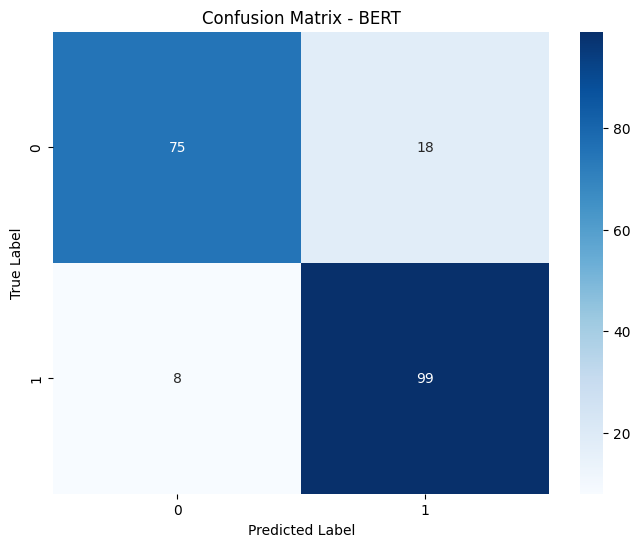

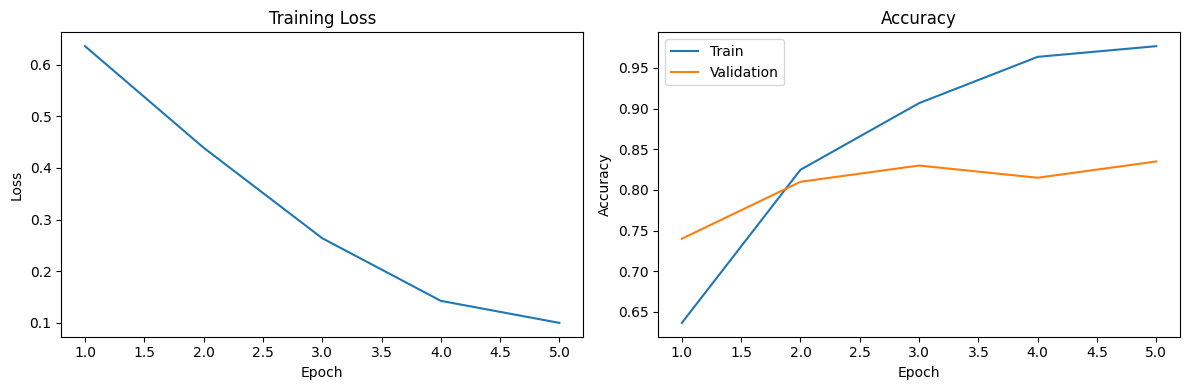

In [10]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_accuracy, test_report, test_cm, predictions, true_labels = evaluate(
    model, test_loader, device
)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BERT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history
epochs_range = list(range(1, epochs+1))
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, [stat['train_loss'] for stat in training_stats])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [stat['train_accuracy'] for stat in training_stats], label='Train')
plt.plot(epochs_range, [stat['val_accuracy'] for stat in training_stats], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Save the model
print("Saving model...")
model_save_path = 'bert_model'
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Save the model state dictionary
torch.save(model.state_dict(), os.path.join(model_save_path, 'bert_model_state.bin'))

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")

Saving model...
Model and tokenizer saved to bert_model


In [14]:
# Function to classify text
def classify_text(text):
    # Preprocess
    model.eval()
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
    
    # Get prediction and confidence
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    prediction = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][prediction].item()
    
    result = {
        'prediction': 'AI-generated' if prediction == 1 else 'Human-generated',
        'confidence': confidence,
        'label': prediction
    }
    
    return result

# Test with some examples
test_texts = [
    "The multiple-objectives are in the form of targets to be achieved for warranty attractiveness index, warranty cost, spare parts cost to the end user over the useful life of the product and mean time between failures.",
    "Next, using the selected sequences as a foundation, we apply optimization techniques like GRASP and Simulated Annealing to generate alternative learning material options, enhancing ACS recommendations. This approach ultimately aids teachers in curating their instructional content more effectively.",

]

for i, text in enumerate(test_texts):
    result = classify_text(text)
    print(f"\nExample {i+1}:")
    print(f"Text: {text[:100]}...")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")


Example 1:
Text: The multiple-objectives are in the form of targets to be achieved for warranty attractiveness index,...
Prediction: Human-generated
Confidence: 0.9991

Example 2:
Text: Next, using the selected sequences as a foundation, we apply optimization techniques like GRASP and ...
Prediction: AI-generated
Confidence: 0.9891


In [20]:
# Interactive text classification
from IPython.display import clear_output

def interactive_classifier():
    while True:
        # Get user input
        text = input("Enter text to classify (or type 'exit' to quit): ")
        
        if text.lower() == 'exit':
            print("Exiting...")
            break
        
        if not text.strip():
            print("Please enter some text.")
            continue
        
        # Classify text
        result = classify_text(text)
        
        # Display result
        clear_output(wait=True)
        print(f"Text: {text}")
        print(f"Prediction: {result['prediction']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print("\nEnter text to classify (or type 'exit' to quit): ")

# Run interactive classifier
interactive_classifier()

Text: In this study, we discuss the impact of these developments on the judicial system in several aspects, as cybersecurity laws provide a legal basis for punishing cybercrime perpetrators, and also enhance the ability to investigate and collect digital evidence, and modern legislation also provides effective security measures to protect sensitive data.
Prediction: Human-generated
Confidence: 0.9926

Enter text to classify (or type 'exit' to quit): 
Exiting...
